# Corpus Nummorum (CN) Data Challange

---

**Goethe University Frankfurt am Main**

Summer Semester 2023

<br>

## *Multimodal Fusion Model for  historical coin classification*

---

**Authors:** Bastian Rothenburger, Garegin Ktoian 
<br>

**Contact:** Bastian Rothenburger ([s7072002@rz.uni-frankfurt.de](mailto:s7072002@rz.uni-frankfurt.de))<br>

---

<br>

## Table of Contents

---

- [1 Dataset Preparation](#1-Dataset-Preparation)
  - [1.1 Copy data to working directory](#1.1-Copy-data-to-working-directory)
  - [1.2 Drop classes below training threshold and merge back and frontside](#1.2-Drop-classes-below-training-threshold-and-merge-back-and-frontside)
  - [1.3 Apply train test split](#1.3-Apply-train-test-split)
  - [1.4 Add original coin descriptions](#1.4-Add-original-coin-descriptions)
- [2 Generation and embedding of alternative descriptions](#2-Generation-and-embedding-of-alternative-descriptions)
  - [2.1 Unique descriptions](#2.1-Unique-descriptions)
  - [2.2 Alternative descriptions](#2.2-Alternative-descriptions)
  - [2.3 Embbeding](#2.3-Embbeding)
- [3 Training](#3-Training)
  - [3.1 Setting training variables](#3.1-Setting-training-variables)
  - [3.2 ImageEncoder Training](#3.2-ImageEncoder-Training)
  - [3.3 TextEncoder Training](#3.3-TextEncoder-Training)
  - [3.4 Fusion Model Training](#3.4-Fusion-Model-Training)
- [4 Summary](#4-Summary)

<br>

## Setup

---

In [1]:

from ModelTrainer import ModelTrainer
import torchvision
from torchvision.models.resnet import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights, resnet101, ResNet101_Weights 
from torchvision.models import swin_v2_b ,Swin_V2_B_Weights
import torchvision.models as models
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from DataPrep import copy_data_folder, create_csv_dataset, drop_empty_classes, merge_images, add_class_index, split_dataset, val_train_csv, add_type_description_to_csv, sanity_check, clean_image_folders
from ChatGptHelper import extract_unique_labels, generate_alternative_descriptions, generate_embeddings
from Architectures import TextClassefier, Transformer_TextClassifier, Fusion, Fusion_From_Scratch
# Check GPU support on your machine.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
%load_ext autoreload
%autoreload 2

cuda:0


In [2]:
#specify path to root folder

dir = r"F:\Users\basti\Documents\Goethe Uni\Data Challange\muldimodal- Mints"

# 1 Dataset Preparation

---

### 1.1 Copy data to working directory

In [14]:
Path_to_coin_dataset = r"F:\Users\basti\Documents\Goethe Uni\Data Challange\CN_dataset_04_23\dataset_mints - Original"
destination_path = dir+ "\\data\\dataset_mints"

if not os.path.exists(destination_path):
    copy_data_folder(Path_to_coin_dataset, dir+ "\\data\\dataset_mints" )

### 1.2 Drop classes below training threshold and merge back and frontside

In [15]:
#data prep
# Create the dataset CSV file
IMAGE_DIR = dir + "\\data\\dataset_mints"
CSV_FILE = "allcoins.csv"

create_csv_dataset(IMAGE_DIR, CSV_FILE)

#clean classes with not enough samples
#specify threshold
clean_image_folders(CSV_FILE, IMAGE_DIR, 20)
CSV_FILE2 = "trainablecoins.csv"
create_csv_dataset(IMAGE_DIR, CSV_FILE2)


# we add a class index in order to make the labels trainable
# the reverse mapping is saved at class_index_map.pkl as a python dict this can be used to translate
# the prediction of the model to the real coin
add_class_index(CSV_FILE2)

Number of Classes with samples 83


### 1.3 Apply train test split

In [18]:
# only run this one time
# this allows for adding augmentations just to the training and not to the validation set

Already_splitted = True
if not Already_splitted:
    dataset_path = dir + "\\data\\dataset_mints"
    train_path = dir + "\\data\\train"
    validation_path = dir + "\\data\\val"
    validation_percentage = 0.25 
    seed = 123
    split_dataset(dataset_path, train_path, validation_path, validation_percentage, seed)
    
    val_train_csv('trainablecoins.csv', train_path, dir, 'train.csv')
    val_train_csv('trainablecoins.csv', validation_path, dir, 'val.csv')

### 1.4 Add original coin descriptions

In [19]:
add_type_description_to_csv('train.csv', 'CN_coin_descriptions.csv', 'train.csv')
add_type_description_to_csv('val.csv', 'CN_coin_descriptions.csv', 'val.csv')

#Sanity check
sanity_check('train.csv', 'val.csv', 20)

f:\Users\basti\Documents\Goethe Uni\Data Challange\muldimodal- Mints\DataPrep.py:284: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df2[['id', 'description']] = df2['combined'].str.split(',', 1, expand=True)
f:\Users\basti\Documents\Goethe Uni\Data Challange\muldimodal- Mints\DataPrep.py:284: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df2[['id', 'description']] = df2['combined'].str.split(',', 1, expand=True)


Your training data contains 83 distinct classes that have more than 20 values and have a description available
Your validation data contains 83 distinct classes that have more than 20 values and have a description available
You should be good to go


# 2 Generation and embedding of alternative descriptions

---

### 2.1 Unique descriptions (omitted for mints)

In [52]:
# doing this for just the training set is sufficient as classes match
#reason for this are the api costs
#extract_unique_labels('train.csv', 'unique_labels.csv')

### 2.2 Alternative descriptions (omitted for mints)

In [53]:
"""
You need an API key to run this
We used GPT4 
Standard open AI accounts will only have access to weaker models (as of the the time of the experiment)
We recommend using text-davinci-003 in this case
In order to specify the model go to ChatGptHelper and change it in get_alternative_description
Takes roughly 50 min for 95 classes
Also you have to clean the resulting file manually we are not sure what causes the issues
All descriptions should be there but some will extend to the second columns

API_key = 'Your API key'

if not os.path.exists(dir + "\\alternative_descriptions_train.csv"):
    generate_alternative_descriptions(API_key, 'unique_labels.csv', 'alternative_descriptions_train.csv')
if not os.path.exists(dir + "\\alternative_descriptions_val.csv"):
    generate_alternative_descriptions(API_key,'unique_labels.csv', 'alternative_descriptions_val.csv')
"""

### 2.3 Embbeding

In [21]:
"""
disclaimer the output for alternative descriptions is to cmplicated to be split by csv_read or i am simply to stupid
if you use excels text to columns function with delimeter , and save
you can use csv_read with delimeter ; afterwards and it works just fine

"""

API_key = 'Your API key'

if not os.path.exists(dir + "\\embeddings_train.npy"):
    generate_embeddings(API_key, 'train.csv', 'text-embedding-ada-002', 'embeddings_train.npy')
if not os.path.exists(dir + "\\embeddings_val.npy"):
    generate_embeddings(API_key, 'val.csv', 'text-embedding-ada-002', 'embeddings_val.npy')

print(np.load('embeddings_val.npy').shape)
print(np.load('embeddings_train.npy').shape)

0 / 21008 generated
1000 / 21008 generated
2000 / 21008 generated
3000 / 21008 generated
4000 / 21008 generated
5000 / 21008 generated
6000 / 21008 generated
7000 / 21008 generated
8000 / 21008 generated
9000 / 21008 generated
10000 / 21008 generated
11000 / 21008 generated
12000 / 21008 generated
13000 / 21008 generated
14000 / 21008 generated
15000 / 21008 generated
16000 / 21008 generated
17000 / 21008 generated
18000 / 21008 generated
19000 / 21008 generated
20000 / 21008 generated
21000 / 21008 generated
0 / 6976 generated
1000 / 6976 generated
2000 / 6976 generated
3000 / 6976 generated
4000 / 6976 generated
5000 / 6976 generated
6000 / 6976 generated
(6976, 1536)
(21008, 1536)


# 3 Training

---

<br>

## 3.1 Setting training variables

---

In [3]:

dir = r"F:\Users\basti\Documents\Goethe Uni\Data Challange\muldimodal- Mints"
model_save_path = dir +"\\models"

# specifies image data 
train, val = dir+"\\train.csv", dir+"\\val.csv"

# specifies language data
train_emb, val_emb   = 'embeddings_train.npy', 'embeddings_val.npy'

# specifies output feature size for imageencoder, textencoder and fusionmodel 
output_features = len(pd.read_csv(train, delimiter=',', skiprows=0, low_memory=False, encoding='iso-8859-1')["class"].unique())


"""
set to true if you want to apply augments
should increase performance slightly (roughly 2-3%)
but also increases training time
"""
use_augments = False

if use_augments:
    train_augmentations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),  # convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # normalize images
    transforms.Resize((299, 299))
    ])
else:
    train_augmentations = transforms.Compose([
    transforms.ToTensor(),  # convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # normalize images
    transforms.Resize((299, 299))
    ])

## 3.2 ImageEncoder Training

---

In [4]:
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

model.fc = nn.Linear(model.fc.in_features, output_features)

# hyperparameters can be set here. Check ModelTrainer.py for details. If not specified differently default values of the Modeltrainer have been used 
Solver = ModelTrainer(model=model,  
            train_path=train,
            train_embedding_path=train_emb, 
            val_path=val,
            val_embedding_path=val_emb, 
            train_augmentations=train_augmentations,
            save_path=model_save_path,
            postfix='ImageEncoder_ResNet18',
            batch_size=16
            )

cuda
21008
torch.Size([16, 3, 299, 299]) torch.Size([16, 83]) torch.Size([16])
data loaded


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------
train Loss: 1.9933 Acc: 0.4923
val Loss: 1.4453 Acc: 0.6056
Epoch 2/10
----------
train Loss: 1.1967 Acc: 0.6757
val Loss: 1.0872 Acc: 0.6894
Epoch 3/10
----------
train Loss: 0.8009 Acc: 0.7788
val Loss: 0.9384 Acc: 0.7337
Epoch 4/10
----------
train Loss: 0.5101 Acc: 0.8616
val Loss: 0.9338 Acc: 0.7431
Epoch 5/10
----------
train Loss: 0.1908 Acc: 0.9585
val Loss: 0.7539 Acc: 0.7942
Epoch 6/10
----------
train Loss: 0.0858 Acc: 0.9881
val Loss: 0.7467 Acc: 0.8002
Epoch 7/10
----------
train Loss: 0.0513 Acc: 0.9941
val Loss: 0.8016 Acc: 0.7858
Epoch 8/10
----------
train Loss: 0.0367 Acc: 0.9955
val Loss: 0.8876 Acc: 0.7681
Epoch 9/10
----------
train Loss: 0.0148 Acc: 0.9994
val Loss: 0.7210 Acc: 0.8126
Epoch 10/10
----------
train Loss: 0.0070 Acc: 0.9999
val Loss: 0.7317 Acc: 0.8081


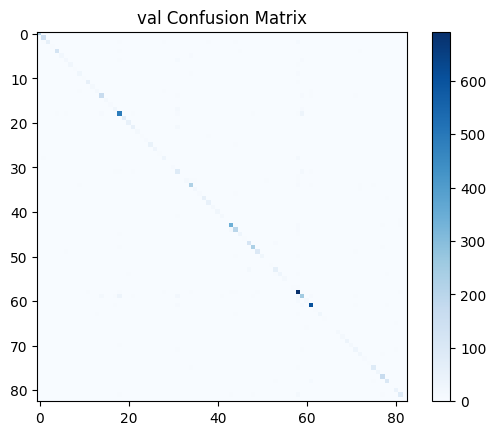


Best val Acc: 0.812643


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:

Solver.train()

## 3.3 TextEncoder Training

---

In [4]:

model = TextClassefier(input_size=1536, hidden_size=10000, output_size=output_features)

# hyperparameters can be set here. Check ModelTrainer.py for details. If not specified differently default values of the Modeltrainer have been used 
Solver = ModelTrainer(model=model,  
            train_path=train, 
           train_embedding_path=train_emb, 
            val_path=val,
            val_embedding_path=val_emb, 
            train_augmentations=train_augmentations,
            save_path=model_save_path,
            postfix='TextEncoder',
            batch_size=4
            )

cuda
21008
torch.Size([4, 3, 299, 299]) torch.Size([4, 83]) torch.Size([4, 1536])
data loaded


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------
train Loss: 2.0621 Acc: 0.5017
val Loss: 1.3816 Acc: 0.6461
Epoch 2/10
----------
train Loss: 1.1664 Acc: 0.6937
val Loss: 0.9771 Acc: 0.7480
Epoch 3/10
----------
train Loss: 0.9056 Acc: 0.7551
val Loss: 0.8123 Acc: 0.7810
Epoch 4/10
----------
train Loss: 0.7542 Acc: 0.7935
val Loss: 0.6892 Acc: 0.8129
Epoch 5/10
----------
train Loss: 0.5842 Acc: 0.8381
val Loss: 0.5965 Acc: 0.8380
Epoch 6/10
----------
train Loss: 0.5245 Acc: 0.8519
val Loss: 0.5609 Acc: 0.8486
Epoch 7/10
----------
train Loss: 0.4799 Acc: 0.8636
val Loss: 0.5252 Acc: 0.8595
Epoch 8/10
----------
train Loss: 0.4419 Acc: 0.8746
val Loss: 0.5019 Acc: 0.8635
Epoch 9/10
----------
train Loss: 0.3717 Acc: 0.8927
val Loss: 0.4679 Acc: 0.8783
Epoch 10/10
----------
train Loss: 0.3483 Acc: 0.8986
val Loss: 0.4383 Acc: 0.8817


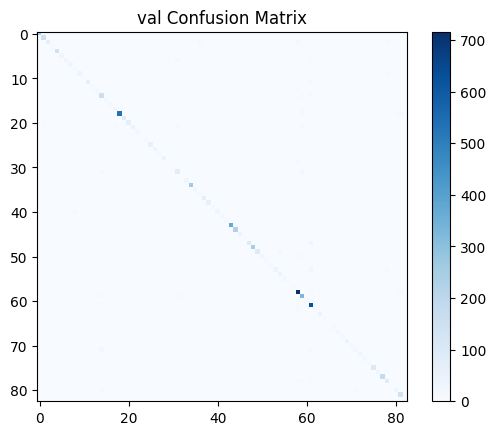


Best val Acc: 0.881737


TextClassefier(
  (fc1): Linear(in_features=1536, out_features=10000, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=10000, out_features=10000, bias=True)
  (fc3): Linear(in_features=10000, out_features=83, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [5]:
Solver.train(mulitmodal=True)

## 3.4 Fusion Model Training

---

In [4]:
TextModel = TextClassefier(input_size=1536, hidden_size=10000, output_size=output_features)
image_encoder = dir + "\\models\modelImageEncoder_ResNet18.tar"
text_encoder = dir + "\\models\modelTextEncoder.tar"
model = Fusion(image_encoder, text_encoder, TextModel, output_size=output_features)

# hyperparameters can be set here. Check ModelTrainer.py for details. If not specified differently default values of the Modeltrainer have been used 
Solver = ModelTrainer(model=model,  
            train_path=train, 
           train_embedding_path=train_emb, 
            val_path=val,
            val_embedding_path=val_emb, 
            train_augmentations=train_augmentations,
            save_path=model_save_path,
            postfix='Fusion',
            batch_size=4,
            )

cuda
21008
torch.Size([4, 3, 299, 299]) torch.Size([4, 83]) torch.Size([4, 1536])
data loaded


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------
train Loss: 1.1639 Acc: 0.7286
val Loss: 0.5948 Acc: 0.8350
Epoch 2/10
----------
train Loss: 0.3796 Acc: 0.9027
val Loss: 0.3848 Acc: 0.8918
Epoch 3/10
----------
train Loss: 0.2204 Acc: 0.9410
val Loss: 0.3718 Acc: 0.9001
Epoch 4/10
----------
train Loss: 0.1584 Acc: 0.9568
val Loss: 0.3911 Acc: 0.8945
Epoch 5/10
----------
train Loss: 0.0860 Acc: 0.9771
val Loss: 0.3420 Acc: 0.9098
Epoch 6/10
----------
train Loss: 0.0732 Acc: 0.9794
val Loss: 0.3400 Acc: 0.9146
Epoch 7/10
----------
train Loss: 0.0651 Acc: 0.9816
val Loss: 0.3934 Acc: 0.9008
Epoch 8/10
----------
train Loss: 0.0574 Acc: 0.9845
val Loss: 0.3787 Acc: 0.9037
Epoch 9/10
----------
train Loss: 0.0423 Acc: 0.9884
val Loss: 0.3555 Acc: 0.9144
Epoch 10/10
----------
train Loss: 0.0374 Acc: 0.9893
val Loss: 0.3262 Acc: 0.9213


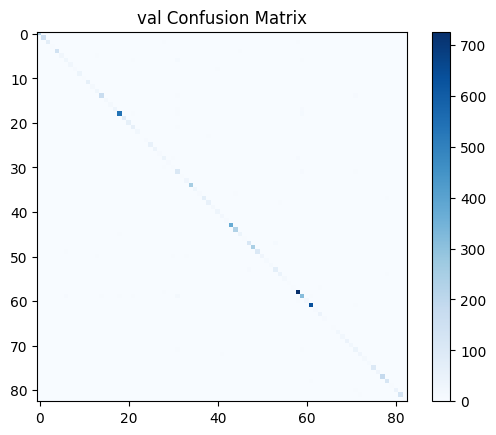


Best val Acc: 0.921302


Fusion(
  (visual_embedding_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [5]:
# multimodel = True allows for the embbeding to be processed by the model. Has to be false if conventinal imagemodels are supposed to be trained
Solver.train(mulitmodal=True)

# 4 Summary

---

In [7]:
print('Summary of results: \n')
checkpoint = torch.load(dir + "\\models\\statsImageEncoder_ResNet18.tar")
acc = []
for i in checkpoint['val_acc']:
    acc.append(i.item())
print('Best valdiation accuracy ImageEncoder:  ', max(acc)*100, '%')
checkpoint = torch.load(dir +"\\models\\statsTextEncoder.tar")
acc = []
for i in checkpoint['val_acc']:
    acc.append(i.item())
print('Best valdiation accuracy TextEncoder:  ', max(acc)*100, '%')
checkpoint = torch.load(dir +"\\models\\statsFusion.tar")
acc = []
for i in checkpoint['val_acc']:
    acc.append(i.item())
print('Best valdiation accuracy FusionModel:  ', max(acc)*100, '%')

Summary of results: 

Best valdiation accuracy ImageEncoder:   81.26433486238533 %
Best valdiation accuracy TextEncoder:   88.17373853211011 %
Best valdiation accuracy FusionModel:   92.13016055045871 %
